In [1]:
%reload_ext autoreload
%autoreload 2

# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = "1"

import time
from copy import copy
import random
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from dominoes import leagueManager as lm
from dominoes import gameplay as dg
from dominoes import agents as da
from dominoes import functions as df
from dominoes import fileManagement as fm
from dominoes import transformers
from dominoes import datasets
from dominoes import training

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
# To-Do List
# 0. Plot valueAgentELO results effectively and document it!
# 1. Train a library of lineValueAgents on a server
# 3. Build a policy-only agent!
#    - It will learn with a network approximation of the value function in the same way the other ones do
#    - But it'll process the hand and game state to generate a context embedding -----
#    - Then use a pointer network to choose which option to play based on the option encoding and the context
#    - The policy can then be updated with the temporal-difference of the value function, which will get more efficient over time

# Experiments: 
# 1. Show that the order of the agents matter (i.e. going after a good agent makes it harder!)
# 2. Compare lineValueNetwork trained on only it's turn vs. all turns vs. just it's turn and the next turn
# 4. Compare value agents trained with hand-continuity of eligibility traces or resets...

# Analysis Goals: 
# 1. look at Linear layer of cnnLayer, find out how similar it is across dominoes
# 2. Same for first linear layer of ffLayer
# 3. Initialize the game many times, look at correlation between average lineValueFeatures and final score output
# 4. Analyze why the abrupt increases in loss happen during pointer demonstration
#    - add the analysis of seqLength vs. loss and position-dependent error to analyze the spikes in the loss

# restructure experiments so they save key data points and divide the data generation and the analysis 
# so I can run it in "analysis" mode where it just loads data from a prespecified filename...
# ---- keeping the above here because I don't think it's done for all of them yet ------


In [266]:
# Immediate to-do
# 1. Finish up transition to REINFORCE algorithm for pointer sequencing
#    - also do this for the pointer demonstration
# 2. Then use a separate value network to force the encoding to learn how to predict the value of the pointer output.
# 3. Switch it to generate an output based on a randomized turn schedule (e.g. possibly be cutoff from generating output and accruing value)
#    - Predict this with a value function too. 
# 4. Divide pointer network into "encoder" and "decoder" blocks to reuse the encoder (and append value)
# 5. Try new versions of pointer attention:
#    - simple attention (not a transformer layer) then single (N -> 1) FF layer
#    - dot product between decoder_context and encoded_representations then softmax over that
# --
# also
# --
# 1. Test simpler TD agents on a probability of winning based value, rather than score!


# Good Coding Practice:
# 1. Convert measure reward to class
# 2. Make a class for all these methods going to the experiments (batch, pad, etc.)

# Representations:
# 1. Make clean and nicely stored system for representing outputs in hand sequencing

Training network...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:12<00:00,  4.06it/s]


Testing network...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  6.04it/s]


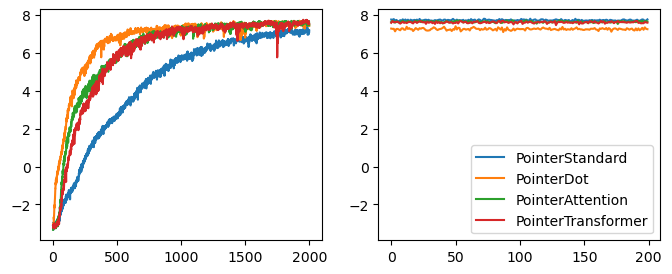

In [19]:
#### set up toy experiment with a simple problem and pointer network to test the REINFORCE algorithm
# start with 'pointerDemonstration' code and reward dominoes in order of highest value, not rewarding already played dominoes, and discounting future dominoes...

# get values from the argument parser
highestDominoe = 9
listDominoes = df.listDominoes(highestDominoe)
dominoeValue = np.sum(listDominoes, axis=1)


# do subselection for training
doubleDominoes = listDominoes[:,0] == listDominoes[:,1]
nonDoubleReverse = listDominoes[~doubleDominoes][:,[1,0]] # represent each dominoe in both orders

# list of full set of dominoe representations and value of each
listDominoes = np.concatenate((listDominoes, nonDoubleReverse), axis=0)
dominoeValue = np.sum(listDominoes, axis=1)

# subset dominoes
keepFraction = 0.75
keepNumber = int(len(listDominoes)*keepFraction)
keepIndex = np.sort(np.random.permutation(len(listDominoes))[:keepNumber]) # keep random fraction (but sort in same way)
keepDominoes = listDominoes[keepIndex]
keepValue = dominoeValue[keepIndex]


ignoreIndex = -1
handSize = 8
batchSize = 512

input_dim = 2*(highestDominoe+1)
embedding_dim = 48
heads = 4
encoding_layers = 1
greedy = True
temperature = 5
thompson = True
maxOutput = handSize

trainEpochs = 2000
testEpochs = 200

gamma = 1.0
exponent = torch.arange(maxOutput).view(-1,1) - torch.arange(maxOutput).view(1,-1)
gamma_transform = (gamma ** exponent * (exponent >= 0)).unsqueeze(0).expand(batchSize, -1, -1).to(device)


# do reinforcement learning
batch_inputs = {'null_token':False, 
                'available_token':False, 
                'ignore_index':ignoreIndex, 
                'return_full':True,
                'return_target':False,
               }

pointer_methods = ['PointerStandard', 'PointerDot', 'PointerAttention', 'PointerTransformer']
pnets = [transformers.PointerNetwork(input_dim, embedding_dim, temperature=temperature, pointer_method=pointer_method, thompson=thompson,
                                     encoding_layers=encoding_layers, heads=heads, kqnorm=True, decode_with_gru=False, greedy=greedy)
         for pointer_method in pointer_methods]
pnets = [pnet.to(device) for pnet in pnets]
for pnet in pnets: pnet.train()

# Create an optimizer, Adam with weight decay is pretty good
optimizers = [torch.optim.Adam(pnet.parameters(), lr=1e-3, weight_decay=1e-5) for pnet in pnets]

numNets = len(pnets)

# Train network
print("Training network...")
trainLoss = torch.zeros((trainEpochs, numNets))
trainReward = torch.zeros((trainEpochs, maxOutput, numNets))
for epoch in tqdm(range(trainEpochs)):
    batch = datasets.generateBatch(highestDominoe, keepDominoes, batchSize, handSize, **batch_inputs)

    # unpack batch tuple
    input, _, _, _, _, selection, available = batch

    # move to correct device
    input = input.to(device)
    
    # zero gradients, get output of network
    for opt in optimizers: opt.zero_grad()
    log_scores, choices = map(list, zip(*[pnet(input, max_output=maxOutput) for pnet in pnets]))

    # log-probability for each chosen dominoe
    logprob_policy = [torch.gather(score, 2, choice.unsqueeze(2)).squeeze(2) for score, choice in zip(log_scores, choices)]
    
    # measure reward
    rewards = [training.measureReward_sortDescend(keepDominoes[selection], choice, normalize=False) for choice in choices]
    G = [torch.bmm(reward.unsqueeze(1), gamma_transform).squeeze(1) for reward in rewards]

    # measure J
    J = [-torch.sum(logpol * g) for logpol, g in zip(logprob_policy, G)]
    for j in J: j.backward()
    
    for opt in optimizers: opt.step()
    
    # save training data
    for i in range(numNets):
        trainLoss[epoch, i] = torch.mean(torch.sum(rewards[i], dim=1))
        trainReward[epoch, :, i] = torch.mean(rewards[i], dim=0)

with torch.no_grad():
    for pnet in pnets: 
        pnet.setTemperature(1)
        pnet.setThompson(False)
        
    print('Testing network...')
    testLoss = torch.zeros((testEpochs, numNets))
    for epoch in tqdm(range(testEpochs)):
        batch = datasets.generateBatch(highestDominoe, listDominoes, batchSize, handSize, **batch_inputs)

        # unpack batch tuple
        input, _, _, _, _, selection, available = batch
    
        # move to correct device
        input = input.to(device)
        
        # get output of network
        log_scores, choices = map(list, zip(*[pnet(input, max_output=maxOutput) for pnet in pnets]))
    
        # log-probability for each chosen dominoe
        logprob_policy = [torch.gather(score, 2, choice.unsqueeze(2)).squeeze(2) for score, choice in zip(log_scores, choices)]
        
        # measure reward
        rewards = [training.measureReward_sortDescend(listDominoes[selection], choice, normalize=False) for choice in choices]
        
        # save training data
        for i in range(numNets):
            testLoss[epoch, i] = torch.mean(torch.sum(rewards[i], dim=1))

plt.close('all')
fig, ax = plt.subplots(1,2,figsize=(8,3))
for inet in range(numNets):
    ax[0].plot(range(trainEpochs), trainLoss[:,inet].detach().cpu().numpy(), label=pointer_methods[inet])
    ax[1].plot(range(testEpochs), testLoss[:,inet].detach().cpu().numpy(), label=pointer_methods[inet])

ylims = ax[0].get_ylim()
ax[1].set_ylim(ylims)
ax[1].legend(loc='lower right')
plt.show()


In [17]:
# order of operations:
# 4. write documentation file explaining the experiment

In [58]:
# prepare inputs for network inspection

# get a "normal" batch
batch = datasets.generateBatch(highestDominoe, listDominoes, batchSize, handSize, **batch_inputs)

# unpack batch tuple
input, _, _, _, _, selection, available = batch
input = input.to(device)

# pre-forward
batch_size, tokens, _ = input.size()
mask = torch.ones((batch_size, tokens), dtype=input.dtype).to(device)

# encoding
embedded = [pnet.embedding(input) for pnet in pnets]
encoded = [pnet.encoding(embed) for pnet, embed in zip(pnets, embedded)]

numerator= [torch.sum(enc*mask.unsqueeze(2), dim=1) for enc in encoded]
denominator = [torch.sum(mask, dim=1, keepdim=True) for _ in pnets]
decoder_context = [num/den for num, den in zip(numerator, denominator)]
decoder_input = [torch.zeros((batch_size, pnet.embedding_dim)).to(device) for pnet in pnets]

# decoding
updated_context = [pnet.pointer.decode(encode, di, dc, mask) for pnet, encode, di, dc in zip(pnets, encoded, decoder_input, decoder_context)]
decoder_state = [pnet.pointer.get_decoder_state(di, uc) for pnet, di, uc in zip(pnets, decoder_input, updated_context)]

# pointer-type specific routines
# .... after this ....

In [64]:
idx_dotnet = {val: idx for idx, val in enumerate(pointer_methods)}['PointerDot']

tEncoded = pnets[idx_dotnet].pointer.pointer.W1(encoded[idx_dotnet])
tDecoded = pnets[idx_dotnet].pointer.pointer.W2(decoder_state[idx_dotnet])
u = torch.bmm(tEncoded, tDecoded.unsqueeze(2)).squeeze(2)

In [ ]:
numDominoes = len(listDominoes)
dominoe_tencoded = torch.zeros((numDominoes, tEncoded.shape[2]), dtype=torch.float).to(device)
dominoe_count = torch.zeros((numDominoes,), dtype=torch.float).to(device)
for ii in range(tEncoded.size(0)):
    for jj in range(tEncoded.size(1)):
        dominoe_tencoded[selection[ii,jj]] += tEncoded[ii,jj]
        dominoe_count[selection[ii,jj]] += 1


In [ ]:
# Tensor.scatter_(dim, index, src, reduce=None) → Tensor
# Writes all values from the tensor src into self at the indices specified in the index tensor. For each value in src, its output index is specified by its index in src for dimension != dim and by the corresponding value in index for dimension = dim.

# For a 3-D tensor, self is updated as:

# self[index[i][j][k]][j][k] = src[i][j][k]  # if dim == 0
# self[i][index[i][j][k]][k] = src[i][j][k]  # if dim == 1
# self[i][j][index[i][j][k]] = src[i][j][k]  # if dim == 2
# This is the reverse operation of the manner described in gather().

In [62]:
tEncoded.shape

torch.Size([512, 8, 48])

In [63]:
tDecoded.shape

torch.Size([512, 48, 1])